In [1]:
import torch.nn.functional as F
from timeit import default_timer
from utilities3 import *
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import scipy as sp
import scipy.ndimage

import skfmm
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.nn import relu

import itertools
from functools import partial
from torch.utils import data
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from scipy.stats.qmc import Halton
from mpl_toolkits.axes_grid1 import make_axes_locatable
torch.manual_seed(0)
np.random.seed(0)
import sys
print(sys.path)

['/home/g202321530/anaconda3/envs/pytorch/lib/python311.zip', '/home/g202321530/anaconda3/envs/pytorch/lib/python3.11', '/home/g202321530/anaconda3/envs/pytorch/lib/python3.11/lib-dynload', '', '/home/g202321530/anaconda3/envs/pytorch/lib/python3.11/site-packages', '/home/g202321530/anaconda3/envs/pytorch/lib/python3.11/site-packages/EikoNet-0.1.0-py3.11.egg', '/home/g202321530/anaconda3/envs/pytorch/lib/python3.11/site-packages/pandas-2.2.0-py3.11-linux-x86_64.egg', '/home/g202321530/anaconda3/envs/pytorch/lib/python3.11/site-packages/tzdata-2023.4-py3.11.egg', '/home/g202321530/anaconda3/envs/pytorch/lib/python3.11/site-packages/pytz-2023.3.post1-py3.11.egg']


In [2]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class U_net(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dropout_rate):
        super(U_net, self).__init__()
        self.input_channels = input_channels
        self.conv1 = self.conv(input_channels, output_channels, kernel_size=kernel_size, stride=2, dropout_rate = dropout_rate)
        self.conv2 = self.conv(input_channels, output_channels, kernel_size=kernel_size, stride=2, dropout_rate = dropout_rate)
        self.conv2_1 = self.conv(input_channels, output_channels, kernel_size=kernel_size, stride=1, dropout_rate = dropout_rate)
        self.conv3 = self.conv(input_channels, output_channels, kernel_size=kernel_size, stride=2, dropout_rate = dropout_rate)
        self.conv3_1 = self.conv(input_channels, output_channels, kernel_size=kernel_size, stride=1, dropout_rate = dropout_rate)
        
        self.deconv2 = self.deconv(input_channels, output_channels)
        self.deconv1 = self.deconv(input_channels*2, output_channels)
        self.deconv0 = self.deconv(input_channels*2, output_channels)
    
        self.output_layer = self.output(input_channels*2, output_channels, 
                                         kernel_size=kernel_size, stride=1, dropout_rate = dropout_rate)


    def forward(self, x):
        out_conv1 = self.conv1(x) #[10, 32, 48, 48] --> [10, 32, 24, 24]
        #print('size of x',x.size())        
        # print('size of out_conv1',out_conv1.size(), x.size())
        out_conv2 = self.conv2_1(self.conv2(out_conv1)) #[10, 32, 24, 24] --> ?[10, 32, 12, 12]? --> [10, 32, 12, 12]
        out_conv3 = self.conv3_1(self.conv3(out_conv2)) #[10, 32, 12, 12] --> ?[10, 32,  6,  6]? --> [10, 32,  6,  6]
        # print('size of out_conv3',out_conv3.size())
        out_deconv2 = self.deconv2(out_conv3) #[10, 32, 6, 6] --> [10, 32, 12, 12]
        # print('size of out_conv2',out_conv2.size())
        # print('size of out_deconv2',out_deconv2.size())
        concat2 = torch.cat((out_conv2, out_deconv2), 1)
        out_deconv1 = self.deconv1(concat2)
        # print('size of out_deconv1',out_deconv1.size())
        concat1 = torch.cat((out_conv1, out_deconv1), 1)
        out_deconv0 = self.deconv0(concat1)
        # print('x, outconv0 shape:', x.size(), out_deconv0.shape)
        concat0 = torch.cat((x, out_deconv0), 1)
        out = self.output_layer(concat0)

        return out

    def conv(self, in_planes, output_channels, kernel_size, stride, dropout_rate):
        return nn.Sequential(
            nn.Conv2d(in_planes, output_channels, kernel_size=kernel_size,
                      stride=stride, padding=(kernel_size - 1) // 2, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout_rate)
        )

    def deconv(self, input_channels, output_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size=4,
                               stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def output(self, input_channels, output_channels, kernel_size, stride, dropout_rate):
        return nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size,
                         stride=stride, padding=(kernel_size - 1) // 2)


class UFNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width, padding=8): # I add
        super(UFNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = padding #7#15 # pad the domain if input is non-periodic 
        #### PADDING WAS MOVED AS AN ARGUMENT TO HANDLE SITUATIONS WHERE THE RESOLUTION DOESN'T PERMIT U-NET
        #### I.E DECONVOLUTION PART OF U-NET DOESN'T REPRODUCE INITIAL CONV-ED INPUT
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)        
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv5 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        
        self.unet3 = U_net(self.width, self.width, 3, 0)
        self.unet4 = U_net(self.width, self.width, 3, 0)
        self.unet5 = U_net(self.width, self.width, 3, 0)

        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 3, padding=1)
        self.w2 = nn.Conv2d(self.width, self.width, 5, padding=2)
        self.w3 = nn.Conv2d(self.width, self.width, 7, padding=3)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.w5 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        # x = torch.mul(x1, x2)
        x_1 = F.gelu(x)
        # x_1 = nn.LeakyReLU(0.2)(x)

        x1 = self.conv1(x_1)
        x2 = self.w1(x_1)
        # x = x1 + x2
        x = torch.mul(x1, x2)
        x_2 = F.gelu(x)
        # x_2 = nn.LeakyReLU(0.2)(x)

        x1 = self.conv2(x_1)
        x2 = self.w2(x_1)
        # x = x1 + x2
        x = torch.mul(x1, x2)
        x_3 = F.gelu(x)
        # x_3 = nn.LeakyReLU(0.2)(x)

        #print('b4 ufno layer size of x',x.size())
        x1 = self.conv3(x_1)
        x2 = self.w3(x_1)#.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        # x3 = self.unet3(x_1) 
        # x = x1 + x2 + x3
        x = torch.mul(x1, x2)
        x_4 = F.gelu(x) 
        # x_4 = nn.LeakyReLU(0.2)(x)

        x = x_2 + x_3 + x_4
        
        x1 = self.conv4(x)
        x2 = self.w4(x)#.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x3 = self.unet4(x)
        x = x1 + x2 + x3
        x = F.gelu(x)  
        # x = nn.LeakyReLU(0.2)(x)
        
        x1 = self.conv5(x)
        x2 = self.w5(x)#.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x3 = self.unet5(x)
        x = x1 + x2 + x3
        x = F.gelu(x)
        # x = nn.LeakyReLU(0.2)(x)

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

def plot_figure_gpu_1(fig_plot, shape=[240, 736], title='Predicted tau'):
    plt.style.use('default')

    plt.figure(figsize=(6,4))
    fig_plot = fig_plot.cpu()
    fig_plot = fig_plot.detach().numpy()
    fig_plot = np.reshape(fig_plot, shape)
    ax = plt.gca()
    im = ax.imshow(fig_plot, aspect='auto', cmap="jet")


    plt.xlabel('Offset (km)', fontsize=12)
    plt.xticks(fontsize=10)

    plt.ylabel('Depth (km)', fontsize=12)
    plt.yticks(fontsize=10)


    plt.title(title, fontsize=15, fontweight='bold')

    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    
    # plt.tight_layout()
    # colorbar = plt.colorbar(im) 
    # # The [left, bottom, width, height] values are in the range [0, 1]
    # colorbar.ax.set_position([0.81, 0.35, 0.25, 0.3])  # Adjust as needed
    # colorbar.set_label('km/s',size=10)
    # colorbar.ax.tick_params(labelsize=10)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad=0.15)

    cbar = plt.colorbar(im, cax=cax, shrink=0.5)

    cbar.set_label('seconds',size=10)
    cbar.ax.tick_params(labelsize=10)
    plt.tight_layout()
    
def plot_figure_cpu_1(fig_plot, shape=[240, 736], title='Diff tau'):
    fig_plot = np.reshape(fig_plot, shape)
    plt.style.use('default')

    plt.figure(figsize=(6,4))
#     Tau_diff = test_y_1-test_predict_1
    ax = plt.gca()
    im = ax.imshow(np.abs(fig_plot), aspect='auto', cmap="jet")

    
    plt.xlabel('Offset (km)', fontsize=14)
    plt.xticks(fontsize=10)

    plt.ylabel('Depth (km)', fontsize=14)
    plt.yticks(fontsize=10)

    plt.title(title, fontsize=15, fontweight='bold')
    

    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    # plt.tight_layout()
    # colorbar = plt.colorbar(im) 
    # # The [left, bottom, width, height] values are in the range [0, 1]
    # colorbar.ax.set_position([0.81, 0.35, 0.25, 0.3])  # Adjust as needed
    # colorbar.set_label('km/s',size=10)
    # colorbar.ax.tick_params(labelsize=10)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad=0.15)

    cbar = plt.colorbar(im, cax=cax, shrink=0.5)

    cbar.set_label('seconds',size=10)
    cbar.ax.tick_params(labelsize=10)
    plt.tight_layout()

def plot_figure_gpu(fig_plot, shape=[240, 736], title='Predicted tau'):

    plt.figure(figsize=(6,4))
    fig_plot = fig_plot.cpu()
    fig_plot = fig_plot.detach().numpy()
    fig_plot = np.reshape(fig_plot, shape)
    ax = plt.gca()
    im = ax.imshow(fig_plot, aspect='auto', cmap="jet")

    plt.xlabel('Offset (km)', fontsize=12)
    plt.xticks(fontsize=10)
    plt.ylabel('Depth (km)', fontsize=12)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=15, fontweight='bold')
    
    plt.tight_layout()
    colorbar = plt.colorbar(im) 
    # The [left, bottom, width, height] values are in the range [0, 1]
    colorbar.ax.set_position([0.81, 0.35, 0.25, 0.3])  # Adjust as needed
    colorbar.set_label('km/s',size=10)
    colorbar.ax.tick_params(labelsize=10)

    

def plot_figure_cpu(fig_plot, shape=[240, 736], title='Diff tau'):
    fig_plot = np.reshape(fig_plot, shape)

    plt.figure(figsize=(6,4))
    ax = plt.gca()
    im = ax.imshow(fig_plot, aspect='auto', cmap="jet")
    
    plt.xlabel('Offset (km)', fontsize=14)
    plt.xticks(fontsize=10)
    plt.ylabel('Depth (km)', fontsize=14)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=15, fontweight='bold')

    plt.tight_layout()
    colorbar = plt.colorbar(im) 
    # The [left, bottom, width, height] values are in the range [0, 1]
    colorbar.ax.set_position([0.81, 0.35, 0.25, 0.3])  # Adjust as needed
    colorbar.set_label('km/s',size=10)
    colorbar.ax.tick_params(labelsize=10)

def to_cpu_reshape(inputs, shape=[240, 736]):
    inputs = inputs.cpu()
    inputs = inputs.detach().numpy()
    inputs = np.reshape(inputs, [240, 736])
    
    return inputs

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


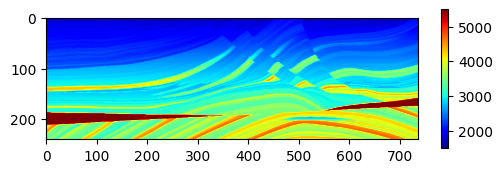

velocity model shape: (240, 736)


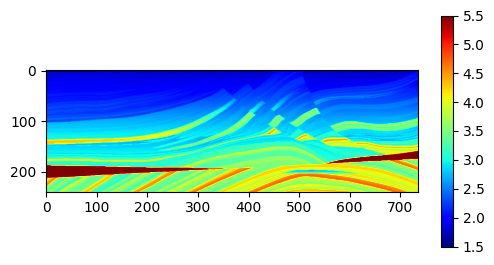

In [3]:
# Model Parameters
grid_size_y = 240   # Grid size
grid_size_x = 736
spacing = 0.01    # Grid spacing
num_sources = 100  # Number of sources
top_vel = 2       # Top velocity for smooth layer velocity model
bottom_vel = 8    # Bottom velocity for smooth layer velocity model
nz=240
nx=737
dx=12.5;dz=12.5;
xm=0+dx*(nx-1);zm=0+dz*(nz-1);


# Generate grid points
x = np.linspace(0, spacing * (grid_size_x - 1), grid_size_x)
y = np.linspace(0, spacing * (grid_size_y - 1), grid_size_y)
xx, yy = np.meshgrid(x, y)

# Retrieve coordinates
coordinates = jnp.dstack((xx, yy)).reshape(-1, 2)

# Create a 1km x 1km smooth velocity grid
# filename="./velmodel/marm_vz.txt"
# marm = pd.read_csv(filename, index_col=None, header=None)
# velocity_model_s = np.reshape(np.array(marm), (101, 101)).T
# velocity_model_s = velocity_model_s[37:, 37:]
# velocity_model_s.shape
# velocity_model_s = top_vel + (bottom_vel - top_vel) * yy / yy.max()

fd = open('./velmodel/marmvx.bin','rb')
velocity_model_s = np.fromfile(fd, dtype = np.float32).reshape([nz,nx],order='F')   #[zxy]
plt.figure(figsize=(6,3))
plt.imshow(velocity_model_s, cmap='jet')
plt.colorbar(shrink=0.6)
plt.show()

velocity_model_1 = velocity_model_s[0:240, 0:736]
# velocity_model = velocity_model_s[250:377, 20:147]
print('velocity model shape:', velocity_model_1.shape)
# # Smooth model 
# sigma_y = 1
# sigma_x = 1
# # velocity_model_s = velocity_model_1
# sigma = [sigma_y, sigma_x]
# velocity_model_s = (sp.ndimage.filters.gaussian_filter(velocity_model_1, sigma, mode='constant'))/1000
# # velocity_model_s = velocity_model_s.T
# velocity_model_s.shape
velocity_model_s = velocity_model_1/1000

plt.figure(figsize=(6,3))
plt.imshow(velocity_model_s, cmap='jet')
plt.colorbar()
plt.show()

In [4]:
# Function to generate random source locations

def generate_random_points(num_sources, dimensions=2, seed=202404):
    # Set random seed for reproducibility
    if seed is not None:
        key = random.PRNGKey(seed)
    else:
        key = random.PRNGKey(0)
        
    # Create a Halton sequence sampler
    sampler = Halton(d=dimensions)
    
    # Generate points
    points = sampler.random(n=num_sources)
    
    # Scale the points to the grid size
    points *= jnp.array([(grid_size_y - 1), (grid_size_x - 1)])
    
    # Convert to integer indices
    points = jnp.round(points).astype(int)
    
    points = jnp.array(list(map(tuple, points)))
    
    return points

In [5]:
# Saves the randomly generated source locations
random_source_loc = generate_random_points(num_sources)
random_source_loc

Array([[ 21, 460],
       [140, 215],
       [ 81, 705],
       [200, 379],
       [ 51, 134],
       [170, 624],
       [111, 297],
       [230,  52],
       [  6, 542],
       [126, 488],
       [ 66, 243],
       [185, 733],
       [ 36, 406],
       [155, 161],
       [ 96, 651],
       [215, 324],
       [ 28,  79],
       [148, 569],
       [ 88, 433],
       [208, 188],
       [ 58, 678],
       [178, 352],
       [118, 107],
       [238, 597],
       [ 13, 270],
       [133,  25],
       [ 73, 515],
       [193, 451],
       [ 43, 206],
       [163, 696],
       [103, 370],
       [223, 125],
       [ 17, 615],
       [137, 288],
       [ 77,  43],
       [196, 533],
       [ 47, 479],
       [167, 234],
       [107, 724],
       [226, 397],
       [  2, 152],
       [122, 642],
       [ 62, 315],
       [182,  70],
       [ 32, 560],
       [152, 424],
       [ 92, 179],
       [211, 669],
       [ 25, 342],
       [144,  97],
       [ 84, 587],
       [204, 261],
       [ 55,

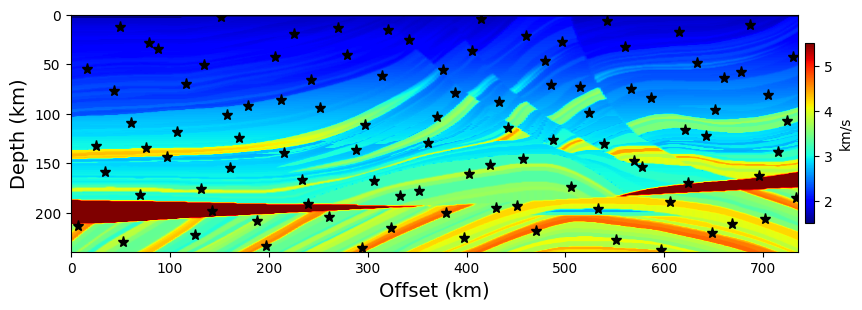

In [6]:
plt.figure(figsize=(10,6))
ax = plt.gca()
im = ax.imshow(velocity_model_s, cmap='jet')
for i in range(num_sources):
    loc = random_source_loc[i, :]
    ax.plot(loc[1],  loc[0],'k*',markersize=8)
plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)
# plt.xticks([0, 100, 200, 300])
# plt.yticks([0, 40, 80, 120])
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="1%", pad=0.15)

plt.tight_layout()
colorbar = plt.colorbar(im) 
# The [left, bottom, width, height] values are in the range [0, 1]
colorbar.ax.set_position([0.81, 0.35, 0.25, 0.3])  # Adjust as needed
colorbar.set_label('km/s',size=10)
colorbar.ax.tick_params(labelsize=10)
plt.savefig(f'./figs/velocity/Modified_ufno_Marmousi_source_num_{num_sources}_e5000_without_smooth_1.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/velocity/Modified_ufno_Marmousi_source_num_{num_sources}_e5000_without_smooth_1.png', bbox_inches="tight", dpi=300)
plt.show()

In [7]:
# Function to generate training data

def gen_data(grid_size_x=grid_size_x,
             grid_size_y=grid_size_y,
             num_sources=num_sources,
             coordinates=coordinates,
             source=None,
             velocity_model=velocity_model_s,
             spacing=spacing):

    V_all = []     # Holds all velocity model
    T0_all = []    # Holds all T0 
    y_coord = []   # Holds all coordinates 
    Tau_all = []   # Holds all Tau values
    T_all = []     # Holds all T

    
    # Source location
    if source == None:    # randomly genrates the location if source locations are not provided
        
        np.random.seed(0)
        loc_y = np.random.choice(range (0, grid_size_y), num_scenarios, replace=False)
        np.random.seed(1)
        loc_x = np.random.choice(range (0, grid_size_x), num_scenarios, replace=False)

        # Adjusted to create a 2D array for source locations
        source_loc = np.stack((loc_y, loc_x), axis=-1)

    else:               # If source locations are provided, sets source location to be the provided points
        source_loc = source


    # For loop to iterate for each source
    for i in range(num_sources):
        
        # Creates a source point for SKFMM using each pair of source location 
        source_point = np.ones((grid_size_y,grid_size_x)) * jnp.inf
        source_point[source_loc[i][0], source_loc[i][1]] = 0

        # Create a 1km x 1km homogeneous velocity grid with value 2
        V0 = jnp.full((grid_size_y, grid_size_x),  velocity_model[source_loc[i][0], source_loc[i][1]])

        # Solve the travel time using the SKFMM
        # print(source_point.shape, velocity_model.shape)
        T = skfmm.travel_time(source_point, velocity_model, dx=spacing, order=2)
        T0 = skfmm.travel_time(source_point, V0, dx=spacing, order=2)
        Tau = T-T0
        
        # Appends dataset to defined list above
        V_all.append(velocity_model)
        T0_all.append(T0)
        y_coord.append(coordinates)
        Tau_all.append(Tau)
        T_all.append(T)
      

    return V_all, T0_all, y_coord, Tau_all, T_all, source_loc

In [8]:
# Generates dataset for 16 random sources
V_data, T0_data, y_data, Tau_data, T_data, sloc_data = gen_data(num_sources=num_sources, source = random_source_loc)
V_data = np.array(V_data)
T0_data = np.array(T0_data)
y_data = np.array(y_data)
Tau_data = np.array(Tau_data)
T_data = np.array(T_data)
sloc_data = np.array(sloc_data)
print(T0_data.shape)

(100, 240, 736)


In [9]:
ntrain = num_sources
# ntest = 100

batch_size = 10
learning_rate = 0.0001
epochs = 5000
# iterations = epochs*(ntrain//batch_size)
# print(iterations)

modes1 = 12
modes2 = 8
width = 64

r = 5
h = int(((421 - 1)/r) + 1)
s = h
print(h, s)

85 85


In [10]:
# T_data = np.load('./train_data/Marmousi_T_50_101.npy')
# T0_data = np.load('./train_data/Marmousi_T0_50_101.npy')
# Tau_data = np.load('./train_data/Marmousi_Tau_50_101.npy')

inputs = T0_data[:, :, :]
inputs = np.reshape(inputs, [num_sources, 240, 736, 1])
inputs = torch.tensor(inputs, requires_grad=True).cuda(1)
inputs = inputs.double()

labels = Tau_data[:, :, :]
labels = torch.tensor(labels, requires_grad=True).cuda(1)
labels = labels.double()

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(inputs, labels), batch_size=batch_size, shuffle=True)

In [11]:
################################################################
# training and evaluation
################################################################
model = UFNO2d(modes1, modes2, width).cuda(1)
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

myloss =  nn.MSELoss()
# myloss =  LpLoss()
# y_normalizer.cuda()

def train():
    Loss = []
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for inputs, labels in train_loader:

            inputs, labels = inputs.cuda(1), labels.cuda(1)
            inputs = inputs.float()
            labels = labels.float()

            optimizer.zero_grad()
            out = model(inputs).reshape(batch_size, 240, 736)
            out = out.float()
            
            loss = myloss(out.view(batch_size,-1), labels.view(batch_size,-1))
            loss.backward()
            
            optimizer.step()
            train_l2 += loss.item()
        scheduler.step()
        t2 = default_timer()

        train_l2 /= ntrain
        Loss.append(train_l2)
        if ep % (epochs // 50) == 0:
            print(f"Epoch: {ep}/{epochs}, Loss: {loss.item()}, Time: {t2-t1}")
        model.eval()
        
    return model, Loss
# %mkdir model
model, Loss = train()

print('[Training] Finished.')
torch.save(model, "./model/UFNO_true_marmousi_120by368_s100_e5000_modified_without_smooth_1")
model.eval()

11558401
Epoch: 0/5000, Loss: 0.11609145998954773, Time: 11.204556101001799
Epoch: 100/5000, Loss: 0.0007228588801808655, Time: 11.158064115792513
Epoch: 200/5000, Loss: 0.0004594815836753696, Time: 11.134153502993286
Epoch: 300/5000, Loss: 0.0002614552213344723, Time: 11.123599926941097
Epoch: 400/5000, Loss: 0.0004868451796937734, Time: 11.148393210954964
Epoch: 500/5000, Loss: 0.000652240589261055, Time: 11.152775074820966
Epoch: 600/5000, Loss: 0.00033905383315868676, Time: 11.1284423568286
Epoch: 700/5000, Loss: 0.00014955112419556826, Time: 11.166274860035628
Epoch: 800/5000, Loss: 0.0001970307348528877, Time: 11.118523844052106
Epoch: 900/5000, Loss: 0.00014003555406816304, Time: 11.155397776979953
Epoch: 1000/5000, Loss: 7.355321577051654e-05, Time: 11.135237583424896
Epoch: 1100/5000, Loss: 0.00010005480726249516, Time: 11.146294394042343
Epoch: 1200/5000, Loss: 2.956717071356252e-05, Time: 11.183289601933211
Epoch: 1300/5000, Loss: 4.33682871516794e-05, Time: 11.1761728189885

UFNO2d(
  (fc0): Linear(in_features=3, out_features=64, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (conv4): SpectralConv2d()
  (conv5): SpectralConv2d()
  (unet3): U_net(
    (conv1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Dropout(p=0, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Dropout(p=0, inplace=False)
    )
    (conv2_1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2

5000


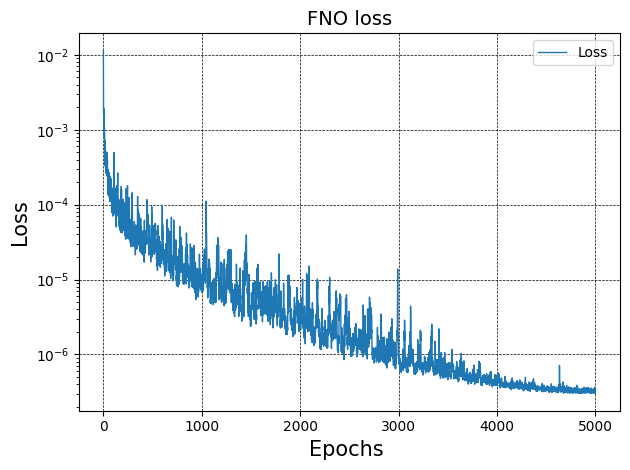

In [12]:
################################################################
# Plotting loss curve
################################################################
print(len(Loss))
plt.semilogy(Loss, label="Loss", linewidth=1) # Plots the total loss

plt.title("FNO loss", fontsize=14)   # Sets the title of the figure

plt.xlabel("Epochs ", fontsize=15)              # Sets the x-axis label of the figure
plt.ylabel("Loss", fontsize=15,)                # Sets the y-axis label of the figure

plt.grid(color = 'black', linestyle = '--', linewidth = 0.5) # Sets the grid of the figure

plt.legend(loc="upper right")   # Sets the legend of the figure

plt.tight_layout()

# %mkdir figs
# plt.savefig("./figs/FNO_Loss_2000_tau_Marmousi_2.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saves the figure
# plt.savefig("./figs/FNO_Loss_2000_tau_Marmousi_2.png", format="png", bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/loss/Loss_modified_ufno_Marmousi_sor{num_sources}_e{epochs}_without_smooth_1.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/loss/Loss_modified_ufno_Marmousi_sor{num_sources}_e{epochs}_without_smooth_1.png', bbox_inches="tight", dpi=300)
plt.show() # Displays the figure

In [331]:
################################################################
# testing an evaluation
################################################################
# T_test = np.load('./test_data/Marmousi_T_101.npy')
# T0_test = np.load('./test_data/Marmousi_T0_101.npy')
# Tau_test = np.load('./test_data/Marmousi_Tau_101.npy')
model = torch.load('./model/UFNO_true_marmousi_120by368_s100_e5000_modified_without_smooth_1')
model.cuda(1)
V_, T0_test, y_, Tau_test, T_test, sloc = gen_data(num_sources=1, source = jnp.array([(221, 648)]))
# source_1 = source = jnp.array([(200,  60)])
source_loc_0, source_loc_1 = 221, 648
source = jnp.array([(221, 648)])
T0_test = np.array(T0_test)
Tau_test = np.array(Tau_test)
T_test = np.array(T_test)

test_x_1 = T0_test
test_x_1 = np.reshape(test_x_1, [1, 240, 736, 1])
test_x_1 = torch.tensor(test_x_1, requires_grad=True).cuda(1)
test_x_1 = test_x_1.float()

test_y_1 = Tau_test
test_y_1 = torch.tensor(test_y_1, requires_grad=True).cuda(1)
test_y_1 = test_y_1.float()


test_predict_1 = model(test_x_1).reshape(240, 736)
print(test_predict_1.shape, T0_test.shape)

torch.Size([240, 736]) (1, 240, 736)


In [332]:
def plot_figure_gpu(fig_plot, shape=[240, 736], title='Predicted tau'):

    plt.figure(figsize=(7,4))
    fig_plot = fig_plot.cpu()
    fig_plot = fig_plot.detach().numpy()
    fig_plot = np.reshape(fig_plot, shape)
    ax = plt.gca()
    im = ax.imshow(fig_plot, aspect='auto', cmap="jet")
    plt.plot(source[1][1], source[0][0],'r*',markersize=12)
    plt.xlabel('Offset (km)', fontsize=12)
    plt.xticks(fontsize=10)
    plt.ylabel('Depth (km)', fontsize=12)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=15, fontweight='bold')
    plt.xticks([0, 200, 400, 600])
    # plt.yticks([0, 200, 400, 600])
    
    plt.tight_layout()
    colorbar = plt.colorbar(im) 
    # The [left, bottom, width, height] values are in the range [0, 1]
    colorbar.ax.set_position([0.81, 0.3, 0.3, 0.5])  # Adjust as needed
    colorbar.set_label('km/s',size=10)
    colorbar.ax.tick_params(labelsize=10)

    
def plot_figure_cpu(fig_plot, shape=[240, 736], title='Diff tau'):
    fig_plot = np.reshape(fig_plot, shape)

    plt.figure(figsize=(7,4))
    ax = plt.gca()
    im = ax.imshow(fig_plot, aspect='auto', cmap="jet")
    plt.plot(source[1][1], source[0][0],'r*',markersize=12)
    plt.xlabel('Offset (km)', fontsize=14)
    plt.xticks(fontsize=10)
    plt.ylabel('Depth (km)', fontsize=14)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=15, fontweight='bold')
    plt.xticks([0, 200, 400, 600])
    # plt.yticks([0, 200, 400, 600])
    
    plt.tight_layout()
    colorbar = plt.colorbar(im) 
    # The [left, bottom, width, height] values are in the range [0, 1]
    colorbar.ax.set_position([0.81, 0.3, 0.3, 0.5])  # Adjust as needed
    colorbar.set_label('km/s',size=10)
    colorbar.ax.tick_params(labelsize=10)


torch.Size([240, 736])


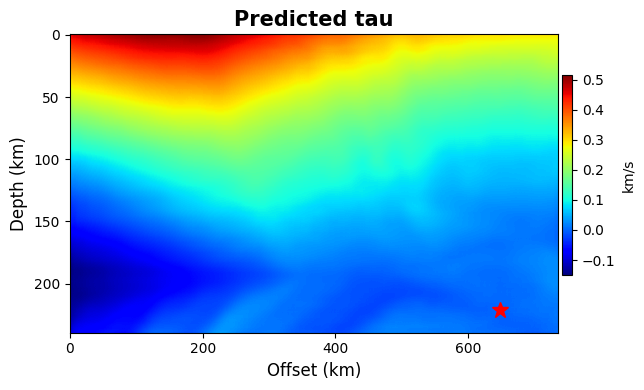

In [333]:
################################################################
# Ploting result
################################################################
from mpl_toolkits.axes_grid1 import make_axes_locatable
zmin = 0.; zmax = 2.; deltaz = 0.02;
xmin = 0.; xmax = 2.; deltax = 0.02;

plot_figure_gpu(test_predict_1, shape=[240, 736], title='Predicted tau')
print(test_predict_1.shape)
# ax.plot(source_1[0][0], source_1[1][1],'k*',markersize=8)
plt.savefig(f'./figs/marmousi_all/modified_ufno_preict_tau_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_preict_tau_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.png', bbox_inches="tight", dpi=300)

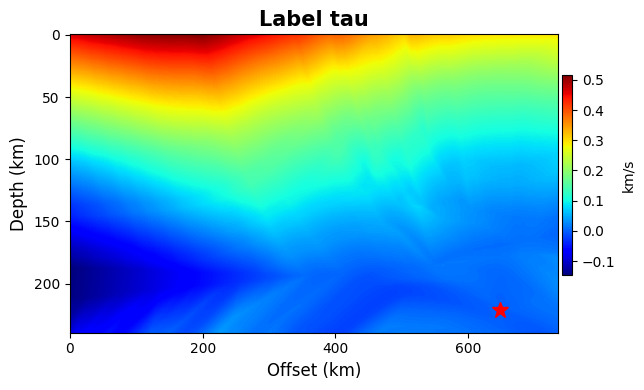

In [334]:
plot_figure_gpu(test_y_1, shape=[240, 736], title='Label tau')

plt.savefig(f'./figs/marmousi_all/modified_ufno_label_tau_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_label_tau_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.png', bbox_inches="tight", dpi=300)

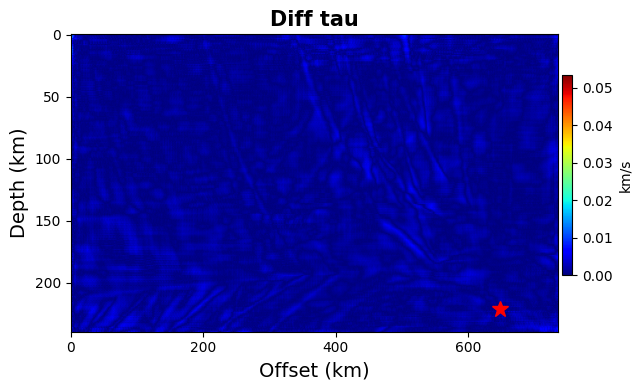

In [335]:
test_y_1 = to_cpu_reshape(test_y_1, shape=[240, 736])
test_predict_1 = to_cpu_reshape(test_predict_1, shape=[240, 736])
Tau_diff = test_y_1-test_predict_1

plot_figure_cpu(np.abs(Tau_diff), title='Diff tau')

# plt.savefig("./figs/fno_diff_tau_Marmousi_2.pdf", format='pdf', bbox_inches="tight", dpi=300)
# plt.savefig("./figs/fno_diff_tau_Marmousi_2.png", format='png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_diff_tau_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_diff_tau_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.png', bbox_inches="tight", dpi=300)

In [336]:
T0_test = np.reshape(T0_test, [240, 736])
T_predict = test_predict_1 + T0_test

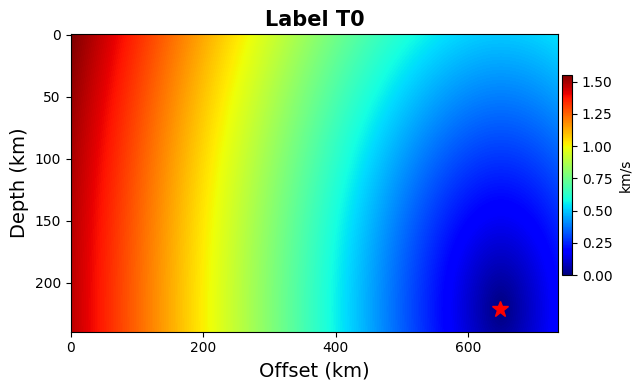

In [337]:
plot_figure_cpu(T0_test, title='Label T0', shape=[240, 736])

plt.savefig(f'./figs/marmousi_all/modified_ufno_label_T0_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_label_T0_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.png', bbox_inches="tight", dpi=300)

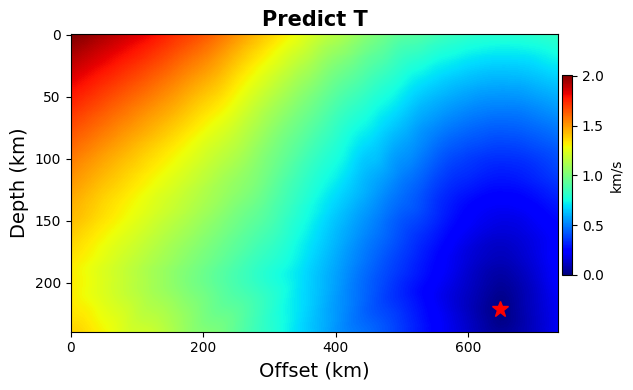

In [338]:
plot_figure_cpu(T_predict, shape=[240, 736], title='Predict T')

# plt.savefig("./figs/fno_predict_T_Marmousi_2.pdf", format='pdf', bbox_inches="tight", dpi=300)
# plt.savefig("./figs/fno_predict_T_Marmousi_2.png", format='png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_predict_T_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_predict_T_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.png', bbox_inches="tight", dpi=300)

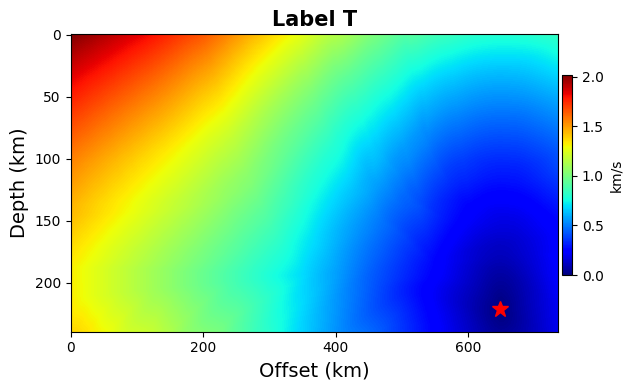

In [339]:
T_test = T0_test + test_y_1
plot_figure_cpu(T_test, shape=[240, 736], title='Label T')

# plt.savefig("./figs/fno_label_T_Marmousi_2.pdf", format='pdf', bbox_inches="tight", dpi=300)
# plt.savefig("./figs/fno_label_T_Marmousi_2.png", format='png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_label_T_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_label_T_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.png', bbox_inches="tight", dpi=300)

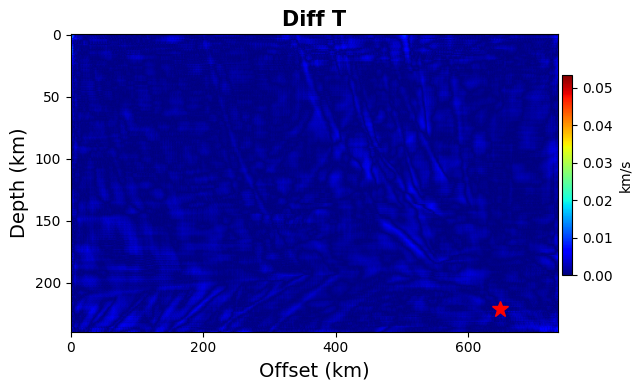

In [340]:
plot_figure_cpu(np.abs(T_predict-T_test), shape=[240, 736], title='Diff T')

# plt.savefig("./figs/fno_diff_T_Marmousi_2.pdf", format='pdf', bbox_inches="tight", dpi=300)
# plt.savefig("./figs/fno_diff_T_Marmousi_2.png", format='png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_diff_T_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_diff_T_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.png', bbox_inches="tight", dpi=300)

(240, 736)


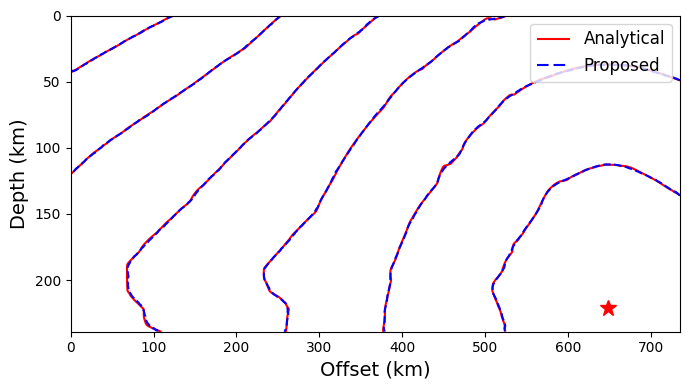

In [341]:
# Traveltime contour plots

plt.figure(figsize=(7,4))
print(T_test.shape)
ax = plt.gca()
im1 = ax.contour(T_test, 6, colors='r')
im2 = ax.contour(T_predict, 6, colors='b',linestyles = 'dashed')
# im3 = ax.contour(T_fsm, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dotted')

ax.plot(source[1][1], source[0][0],'r*',markersize=12)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
# h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0]], ['Analytical', 'Proposed'],fontsize=12)

# ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# ax.plot(source_1[0][0], source_1[1][1],'k*',markersize=8)
plt.tight_layout()

# plt.savefig("./figs/contours_Marmousi_2.pdf", format='pdf', dpi=300)
# plt.savefig("./figs/contours_Marmousi_2.png", format='png', dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_diff_contours_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/marmousi_all/modified_ufno_diff_contours_Marmousi_sor{num_sources}_e{epochs}_{source_loc_0}_{source_loc_1}_without_smooth_1.png', bbox_inches="tight", dpi=300)

In [342]:
# Determining the accuracy of the model by quantifying the difference between T_pred and T_data using Vector Norm
print(np.linalg.norm(T_predict-T_test)/np.linalg.norm(T_test))
print(np.linalg.norm(T_predict-T_test))

0.0015091296736056347
0.6127119939491558


In [343]:
# RMAE comparison of two different methods
print("RMAE of FNO =", 100 * abs(T_predict - T_test).mean() / T_test.mean(), '%')

RMAE of FNO = 0.13124253546647027 %
